In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, auc, f1_score

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src/visualization/')
import visualize as vis

In [2]:
df = pd.read_csv('../data/processed/CriticalPath_Data_EM_Confidential_lessNoise.csv').drop(columns=['Unnamed: 0'])

## XGBoost Model to see which features most impact enrollment.

### Starting Parameters

## Split into training and test data, and fit a regression model.

In [3]:
X = df.drop(columns=['Enrolled','Admission_status',
                     'Unique_student_ID']).select_dtypes([float,bool,int]).fillna(-999)

Y = df['Enrolled'].fillna(-999)


X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [4]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print( "R2 Score: ", r2_score(y_test, y_pred) )

R2 Score:  0.9934576212808314


## Try to find best parameters

In [10]:
# #brute force scan for all parameters, here are the tricks
# #usually max_depth is 6,7,8
# #learning rate is around 0.05, but small changes may make big diff
# #tuning min_child_weight subsample colsample_bytree can have 
# #much fun of fighting against overfit 
# #n_estimators is how many round of boosting
# #finally, ensemble xgboost with multiple seeds may reduce variance

# xgb_model = xgb.XGBRegressor()

# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'learning_rate': [.001, 0.05, .01], #so called `eta` value
#               'max_depth': [2, 5, 10, 20],
#               'min_child_weight': [11],
#               'silent': [1],
#               'subsample': [.2, .5, 0.8],
#               'colsample_bytree': [.2, .5, 0.8],
#               'n_estimators': [5, 50, 500], #number of trees, change it to 1000 for better results
#               'missing':[-999],
#               'seed': [42]}


# clf = GridSearchCV(xgb_model, parameters, n_jobs=6, 
#                    cv=5, verbose=2, refit=True)

In [11]:
# %%time
# clf.fit(X_train, y_train)

## Plot feature importance

In [ ]:
print(model.feature_importances_)

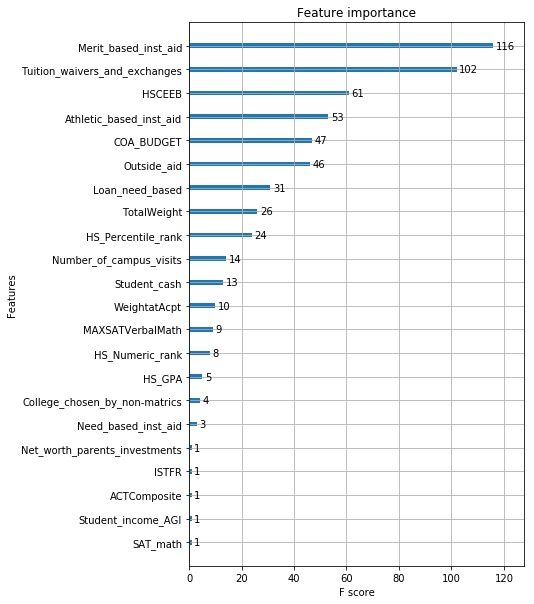

In [6]:
vis.my_plot_importance(model,figsize=(6,10));
plt.savefig("../reports/figures/feature_importance/feature_importance.png")

## Plot shapley values.
* *An intuitive way to understand the Shapley value is the following illustration: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value of a feature value is the average change in the prediction that the coalition already in the room receives when the feature value joins them.*
 
* *The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.*





[cristophm.gihub.io](https://christophm.github.io/interpretable-ml-book/shapley.html):

In [7]:
shap.initjs()
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

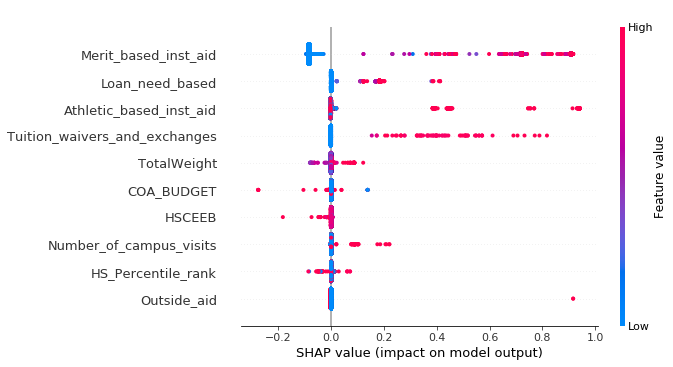

In [8]:
sum_plot = shap.summary_plot(shap_values, X, max_display=10, show=False,
                  plot_type='dot')
plt.savefig("../reports/figures/feature_importance/shapley_summary.png")

## Plot this as a bar chart.

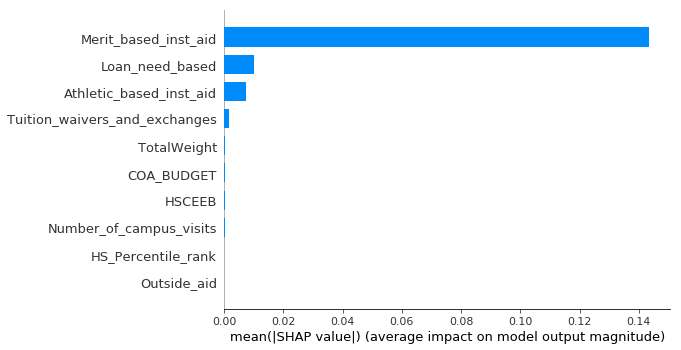

In [9]:
shap.summary_plot(shap_values, X, max_display=10, show=False,
                  plot_type='bar')
plt.savefig("../reports/figures/feature_importance/shapley_summary_bar.png")

## Individual features.

#### X axis is feature value
#### Y axis is the associated shapley value (ouput impact)

#### Red/Blue is a value of potential interaction effect

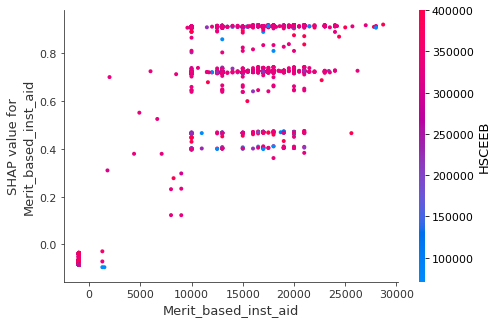

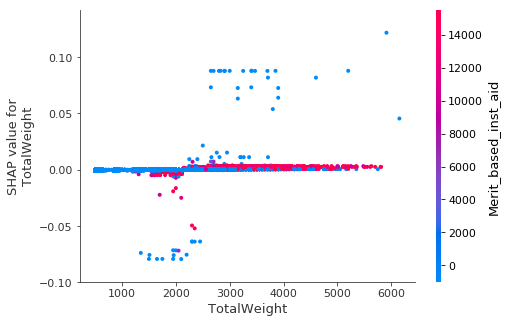

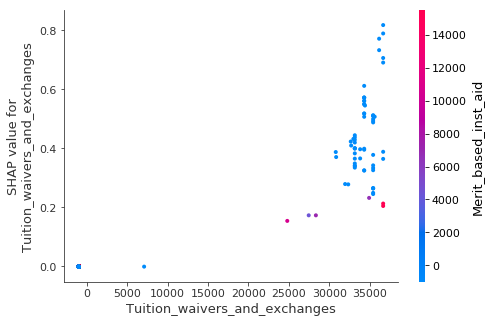

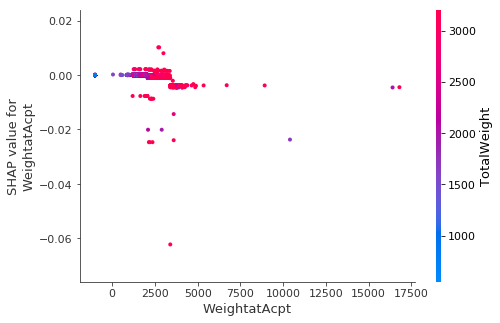

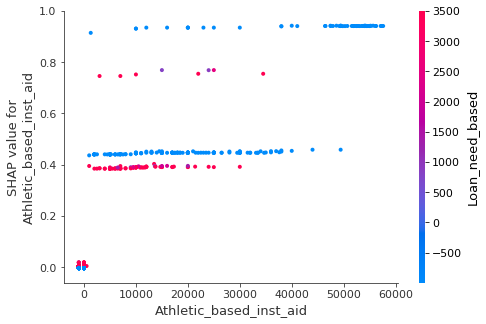

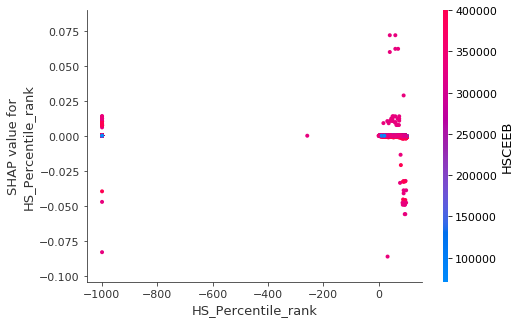

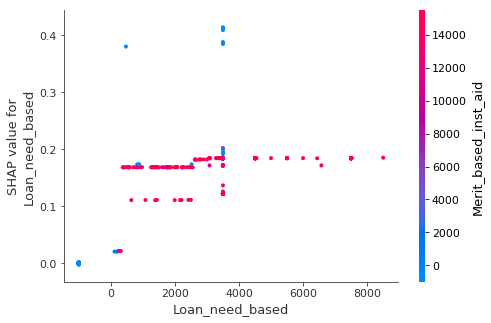

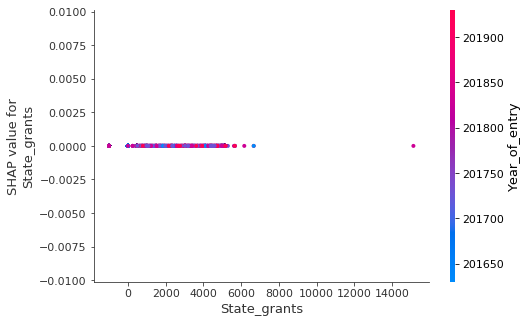

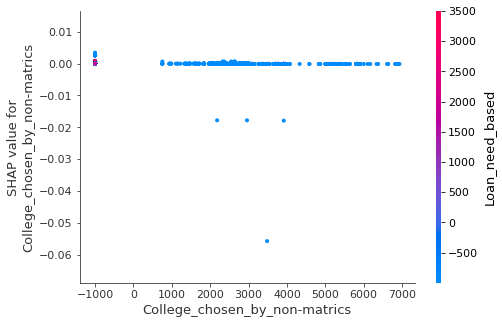

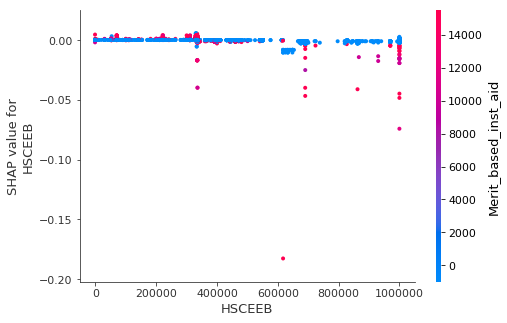

In [10]:
for feature in ["Merit_based_inst_aid","TotalWeight",
               "Tuition_waivers_and_exchanges","WeightatAcpt", 
                "Athletic_based_inst_aid","HS_Percentile_rank",
                "Loan_need_based","State_grants",
               "College_chosen_by_non-matrics","HSCEEB"]:
    
#     print(feature)
    plt.figure()
    shap.dependence_plot(feature, shap_values, X,show=False)
    plt.savefig("../reports/figures/feature_importance/individual_feature-%s.png" % feature)    